# Swithing Kalman filter parameter tuning using synthetic anomalies
This tutorial example presents how to calibrate the hyperparameters of the SSM & LSTM network, as well as the hyperparameters of a switching Kalman filter (SKF) using synthetic anomalies and the external Ray Tune library. The example involves the detection of anomalies that take the form of change points. The model relies on the SKF for estimating the probability of the local trend regime versus a local acceleration regime, whereas a high probability for the later indicates the presence of a change point in a time series.

The calibration of the LSTM neural network relies on the raw traning set that is deemed to be stationnary and the SKF hyperparameters are estimated using synthetic anomalies that are added on the raw traning set. 

In this example, we use a simple sine-like signal onto which we add a synthetic regime change marking the time series swithcing from a stationnary regime to a trend-statinnary one.

### Import libraries
Import the various libraries that will be employed in this example.

In [13]:
import copy
from pathlib import Path
project_root = Path.cwd().resolve().parents[1]
import ray
ray.shutdown()
ray.init(
    runtime_env={
        "working_dir": str(project_root),
        "excludes": [".git"]
    }
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytagi import Normalizer
import pytagi.metric as metric


2025-10-15 15:42:29,607	INFO worker.py:1951 -- Started a local Ray instance.
2025-10-15 15:42:29,644	INFO packaging.py:588 -- Creating a file package for local module '/Users/vuongdai/GitHub/canari'.
2025-10-15 15:42:29,673	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_0871d592f8fc1249.zip' (6.91MiB) to Ray cluster...
2025-10-15 15:42:29,694	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_0871d592f8fc1249.zip'.


### Import from Canari
From Canari, we need to import several classes that will be reused in this example. Notably, we need to import the components that will be used to build the model; In terms of baseline, we the SKF will build two competing models using respectively the `LocalTrend` and `LocalAcceleration` components. The recurrent pattern is modelled using a `LstmNetwork` and the residual is modelled by a `WhiteNoise` compoment.

In [14]:
from canari import (
    DataProcess,
    Model,
    SKF,
    ModelOptimizer,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_states,
    plot_skf_states,
)
from canari.component import LocalTrend, LocalAcceleration, LstmNetwork, WhiteNoise

### Read data
The raw `.csv` data is saved in a dataframe using the Pandas external library.

In [15]:
project_root = Path.cwd().resolve().parents[1]
data_file = str(project_root / "data/toy_time_series/sine.csv")
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
# Add synthetic anomaly to data
trend = np.linspace(0, 0, num=len(df))
time_anomaly = 120
new_trend = np.linspace(0, 1, num=len(df) - time_anomaly)
trend[time_anomaly:] = trend[time_anomaly:] + new_trend
df = df.add(trend, axis=0)
#
data_file_time = str(project_root / "data/toy_time_series/sine_datetime.csv")
time_index = pd.read_csv(data_file_time, skiprows=1, delimiter=",", header=None)
time_index = pd.to_datetime(time_index[0])
df.index = time_index
df.index.name = "time"
df.columns = ["values"]

### Data preprocess
In terms of pre-processsing, we want to add the _hour-of-the-day_ as time-covariate for the LSTM network. Moreover we define here our choice of using the first 40% of the raw time series for trainig and the following 10% for the validaiton set. The remaining last 50% are the implicitely defined as the test set. 

In [16]:
output_col = [0]
data_processor = DataProcess(
    data=df,
    time_covariates=["hour_of_day"],
    train_split=0.4,
    validation_split=0.1,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
data_processor.data.head()

,values,hour_of_day
time,,
2000-01-03 00:00:00,0.00,0
2000-01-03 01:00:00,-0.26,1
2000-01-03 02:00:00,-0.50,2
2000-01-03 03:00:00,-0.71,3
2000-01-03 04:00:00,-0.87,4


### A. Optimize the model hyperparameters
This section presents how Canari relies on the Ray Tune library in order to optimize the hyperparameters for the SSM, the LSTM, and the SKF.

#### A.1. Parameter space
First, we need to define which hyperparameters will be optimized and for each of them what is the range of values to be searched. In this example, we search for the optimal look-back window length between 10 and 30 time steps, and the residual component's standard deviation between 0.001 and 0.2. 

In [17]:
param_space = {
    "look_back_len": [10, 30],
    "sigma_v": [1e-3, 2e-1],
}

#### A.2. Model as a function of parameters
We need to create a function that makes our model depends on the parameters to be search over.

In [18]:
def model_with_parameters(param, train_data, validation_data):
    local_trend = LocalTrend()
    pattern = LstmNetwork(
            look_back_len=param["look_back_len"],
            num_features=2,
            num_layer=1,
            infer_len=24 * 3,
            num_hidden_unit=50,
            manual_seed=1,
        )
    residual = WhiteNoise(std_error=param["sigma_v"])
    model = Model(local_trend, pattern, residual)
    model.auto_initialize_baseline_states(train_data["y"][0:24])

    # Training
    num_epoch = 50
    for epoch in range(num_epoch):
        (mu_validation_preds, std_validation_preds, states) = model.lstm_train(
            train_data=train_data,
            validation_data=validation_data,
        )

        # Unstandardize the predictions
        mu_validation_preds_unnorm = Normalizer.unstandardize(
            mu_validation_preds,
            data_processor.scale_const_mean[data_processor.output_col],
            data_processor.scale_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = Normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.scale_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(
            evaluate_metric=-validation_log_lik,
            current_epoch=epoch,
            max_epoch=num_epoch,
        )
        model.metric_optim = model.early_stop_metric

        if epoch == model.optimal_epoch:
            mu_validation_preds_optim = mu_validation_preds.copy()
            std_validation_preds_optim = std_validation_preds.copy()

        if model.stop_training:
            break


    return model, mu_validation_preds_optim, std_validation_preds_optim


#### A.3. Define optimizer
We instantiate and run the optimizer for our example. The results is a set of optimal hyperparameters for our model. 

In [19]:
model_optimizer = ModelOptimizer(
    model=model_with_parameters,
    param_space=param_space,
    train_data=train_data,
    validation_data = validation_data,
    num_optimization_trial=10,
)
model_optimizer.optimize()

#  1/10 - Metric: -0.833 - Parameter: {'look_back_len': 24, 'sigma_v': 0.16330939348976586}
#  2/10 - Metric: -0.786 - Parameter: {'look_back_len': 27, 'sigma_v': 0.17615339134459385}
#  3/10 - Metric: -1.337 - Parameter: {'look_back_len': 21, 'sigma_v': 0.028413114832550792}
#  4/10 - Metric: -0.863 - Parameter: {'look_back_len': 14, 'sigma_v': 0.18920710038466607}
#  5/10 - Metric: -1.019 - Parameter: {'look_back_len': 15, 'sigma_v': 0.14129671643702657}
#  6/10 - Metric: -1.285 - Parameter: {'look_back_len': 27, 'sigma_v': 0.017762535547598626}
#  7/10 - Metric: -0.833 - Parameter: {'look_back_len': 25, 'sigma_v': 0.1642017159226723}
#  8/10 - Metric: -1.081 - Parameter: {'look_back_len': 10, 'sigma_v': 0.15090860037345524}
#  9/10 - Metric: -1.637 - Parameter: {'look_back_len': 10, 'sigma_v': 0.05259133513166628}


2025-10-15 15:42:43,770	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/Model_optimizer' in 0.0058s.


# 10/10 - Metric: -0.847 - Parameter: {'look_back_len': 26, 'sigma_v': 0.15770266155926593}
-----
Optimal parameters at trial #9: {'look_back_len': 10, 'sigma_v': 0.05259133513166628}
-----


#### A.4 Get optimal model hyperparameters
We then get the best model parameters and set them for our model.

In [20]:
param_optim = model_optimizer.get_best_param()
model_optim, mu_validation_preds, std_validation_preds = model_with_parameters(param_optim, train_data, validation_data)
model_optim_dict = model_optim.get_dict(time_step=0)

#### A.5 Hidden states and predictions
We represent the time-series decomposition visually where the raw data is overlaid with the baseline hidden state represented by the _level_. The rate of change of the baseline is caracterised by the _trend_ and _acceleration_ hidden states. The recurrent pattern is captured by the LSTM neural network. The posterior estimate for the residuals are displayed for the white noise component. 

Note that in this first trainig phase, the results are only presented for the training and validation sets.

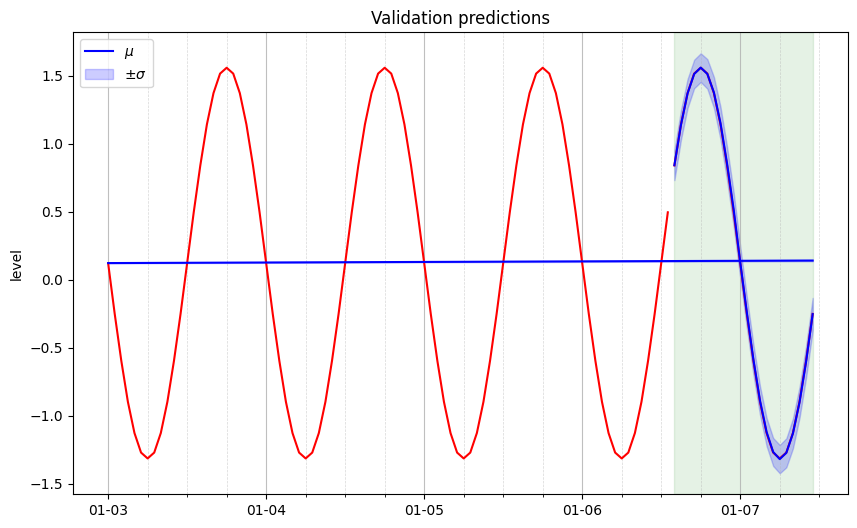

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_data(
    data_processor=data_processor,
    standardization=True,
    plot_test_data=False,
    plot_column=output_col,
    test_label="y",
)
plot_prediction(
    data_processor=data_processor,
    mean_validation_pred=mu_validation_preds,
    std_validation_pred=std_validation_preds,
    validation_label=[r"$\mu$", f"$\pm\sigma$"],
)
plot_states(
    data_processor=data_processor,
    states=model_optim.states,
    standardization=True,
    states_to_plot=["level"],
    sub_plot=ax,
)
plt.legend()
plt.title("Validation predictions")
plt.show()

### B. Optimize the switching Kalman silter (SKF) hyperparameters
In this second step, we again use the Ray Tune library in order to optimize the SKF hyperparameters in order to 1) limit the false alarms, and 2) maximize the detectability of synthetic anomalies.   

#### B.1. hyparameter space
First, we need to define which hyperparameters will be optimized, and for each of them what is the range of values to be searched. In this example, we search for 1) the standard deviation of the process error that is added when transiting from the normal to the abnormal model, 2) the prior probability of having a regime switch fron normal to abnormal, and 3) the slope of the synthetic anomalies that will lead to a 50% detection rate. 

In [22]:
slope_upper_bound = 5e-2
slope_lower_bound = 1e-3
skf_param = {
    "std_transition_error": [1e-6, 1e-3],
    "norm_to_abnorm_prob": [1e-6, 1e-3],
    "slope": [slope_lower_bound, slope_upper_bound],
}

#### B.2. SKF model as a function of parameters
We create a function that will make our model depend on the hyperparameters defined above.

In [23]:
def skf_with_parameters(skf_param, model_param: dict, train_data):
    norm_model = Model.load_dict(model_param)

    local_acceleration = LocalAcceleration()
    pattern = LstmNetwork()
    residual = WhiteNoise()
    abnorm_model = Model(local_acceleration, pattern, residual)

    skf = SKF(
        norm_model=norm_model,
        abnorm_model=abnorm_model,
        std_transition_error=skf_param["std_transition_error"],
        norm_to_abnorm_prob=skf_param["norm_to_abnorm_prob"],
    )
    skf.save_initial_states()
    
    detection_rate, false_rate, false_alarm_train = skf.detect_synthetic_anomaly(
        data=train_data,
        num_anomaly=50,
        slope_anomaly=skf_param["slope"],
    )
    skf.metric_optim["detection_rate"] = detection_rate
    skf.metric_optim["false_rate"] = false_rate
    skf.metric_optim["false_alarm_train"] = false_alarm_train
    
    return skf

#### B.3. Optimizer
We instantiate the optimizer and run it over 40 optimization runs. This procedure will return the optimized hyperparameter values in order to maximize the detectability of the smallest anomalies having a detection rate of 50% while not causing any false detection.

In [24]:
skf_optimizer = SKFOptimizer(
    skf=skf_with_parameters,
    model_param=model_optim_dict,
    param_space=skf_param,
    data=train_data,
    num_optimization_trial=20,
)
skf_optimizer.optimize()

#  1/20 - Metric: 0.050 - Detection rate: 0.04 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 6.262464671412413e-06, 'norm_to_abnorm_prob': 7.954246722071615e-06, 'slope': 0.036341763978233}
#  2/20 - Metric: 0.004 - Detection rate: 0.50 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 0.0001652152868333173, 'norm_to_abnorm_prob': 3.619564459281087e-06, 'slope': 0.004075561687726222}
#  3/20 - Metric: 0.010 - Detection rate: 0.74 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 3.4589282402653024e-05, 'norm_to_abnorm_prob': 3.2265827212687894e-06, 'slope': 0.00956250443427166}
#  4/20 - Metric: 0.008 - Detection rate: 0.90 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 4.346988879841294e-05, 'norm_to_abnorm_prob': 0.0006883839443247778, 'slope': 0.008100056969693936}
#  5/20 - Metric: 0.026 - Detection rate: 1.00 - False rate: 0.00 - False alar

2025-10-15 15:43:10,491	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/SKF_optimizer' in 0.0101s.


# 20/20 - Metric: 0.013 - Detection rate: 1.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 9.849528645139968e-05, 'norm_to_abnorm_prob': 0.0002206028625292635, 'slope': 0.013477375890075567}
-----
Optimal parameters at trial #2: {'std_transition_error': 0.0001652152868333173, 'norm_to_abnorm_prob': 3.619564459281087e-06, 'slope': 0.004075561687726222}
-----


#### B.4. Get optimal SKF
Set the optimized hyperparameters into the model in order to process the data from the test set.

In [25]:
# Get optimal model
skf_param = skf_optimizer.get_best_param()
skf_optim = skf_with_parameters(skf_param, model_optim_dict, train_data)

#### B.5. Anomaly detection
Once the training is complete, we perform the changepoint detection by using the SKF `filter` or `smoother`. The `filter` represents the results obtained during online data processing and the `smoother` those obtained during offline processing.

In [26]:
filter_marginal_abnorm_prob, states = skf_optim.filter(data=all_data)
smooth_marginal_abnorm_prob, states = skf_optim.smoother()

#### B.6. Hidden states and proability of anomalies
We represent the time-series decomposition visually where the raw data is overlaid with the baseline hidden state represented by the _level_. The rate of change of the baseline is characterized by the _trend_ and _acceleration_ hidden states. The recurrent pattern is captured by the LSTM neural network. The posterior estimate for the residuals are displayed for the white noise component. Finaly, the probability of anomaly obtained from the SKF indicated the possible location of change point from a stationnary regime to a trend-stationnary one. 

Note that in this second optimization phase the results now extend into the test set.

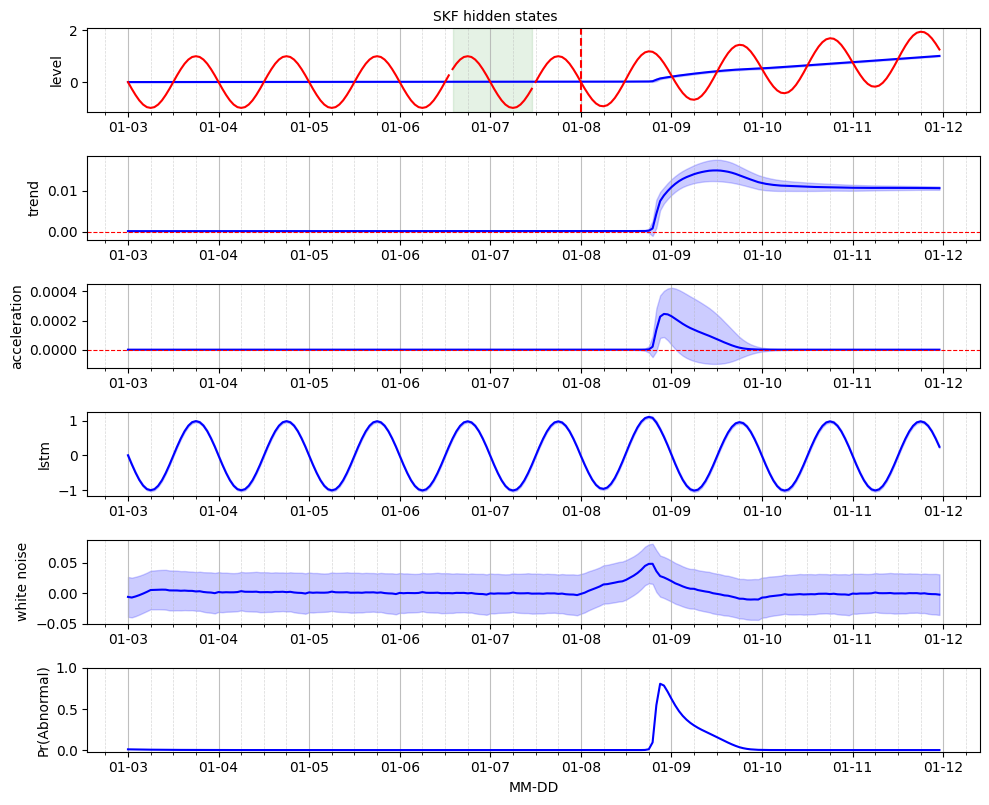

In [27]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    model_prob=filter_marginal_abnorm_prob,
)
ax[0].axvline(
    x=data_processor.data.index[time_anomaly],
    color="r",
    linestyle="--",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)
ax[-1].set_xlabel("MM-DD")
plt.show()